In [2]:
import torch
import triton
import triton.language as tl

# 1 Tile per CTA

- https://triton-lang.org/main/getting-started/tutorials/01-vector-add.html


- Triton编程以CTA（Program / Block）为起始点，每个CTA行为（数据）上的区别使用Program ID / CTA ID区分
    - kernel用于描述一个CTA的运算
    - 类似于cuda的blockIdx和threadIdx
- Triton没有细化到每个 thread 做什么，通过 `tl.arange` 生成 tensor
    - `tl.arange(0, TILE_SIZE)`生成一个从 0 到 TILE_SIZE 的序列

![jupyter](./images/vector_add_1.png)

In [3]:
@triton.jit
def add_kernel(x_ptr,  # 指向第一个输入向量的指针
               y_ptr,  # 指向第二个输入向量的指针
               output_ptr,  # 指向输出向量的指针
               n_elements,  # 向量的大小
               BLOCK_SIZE: tl.constexpr,  # 每个程序处理的元素数量
               ):
    # 标识当前程序的ID，用于处理不同的数据块
    pid = tl.program_id(axis=0)
    # 计算当前程序处理的数据块起始位置
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    # 创建掩码，用于保护内存操作防止越界
    mask = offsets < n_elements
    # 加载输入数据，使用掩码避免越界
    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    # 计算输出并存回DRAM。
    output = x + y
    tl.store(output_ptr + offsets, output, mask=mask)

- wrapper 指定 grid, 启动 kernel

In [4]:
def add(x: torch.Tensor, y: torch.Tensor):
    # 预分配输出张量
    output = torch.empty_like(x)
    assert x.is_cuda and y.is_cuda and output.is_cuda
    n_elements = output.numel()
    # 设置 SPMD 启动网格，类似于 CUDA 启动网格
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )
    # 使用 jit 函数和启动网格创建 GPU 可调用内核
    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)
    # 返回输出句柄，注意内核可能仍在异步运行
    return output

In [5]:
torch.manual_seed(0)
size = 98432
x = torch.rand(size, device='cuda')
y = torch.rand(size, device='cuda')
output_torch = x + y
output_triton = add(x, y)
print(output_torch)
print(output_triton)
print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')

tensor([1.3713, 1.3076, 0.4940,  ..., 0.6724, 1.2141, 0.9733], device='cuda:0')
tensor([1.3713, 1.3076, 0.4940,  ..., 0.6724, 1.2141, 0.9733], device='cuda:0')
The maximum difference between torch and triton is 0.0


In [6]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # 参数名称，用作图表的 x 轴。
        x_vals=[2**i for i in range(12, 28, 1)],  # `x_name` 的不同可能值。
        x_log=True,  # x 轴为对数尺度。
        line_arg='provider',  # 参数名称，其值对应于图中的不同线条。
        line_vals=['triton', 'torch'],  # `line_arg` 的可能值。
        line_names=['Triton', 'Torch'],  # 线条的标签名称。
        styles=[('blue', '-'), ('green', '-')],  # 线条样式。
        ylabel='GB/s',  # y 轴的标签名称。
        plot_name='vector-add-performance',  # 图表的名称，也用作保存图表的文件名。
        args={},  # 不在 `x_names` 和 `y_name` 中的函数参数的值。
    ))

def benchmark(size, provider, add_func):
    x = torch.rand(size, device='cuda', dtype=torch.float32)
    y = torch.rand(size, device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add_func(x, y), quantiles=quantiles)
    gbps = lambda ms: 3 * x.numel() * x.element_size() / ms * 1e-6
    return gbps(ms), gbps(max_ms), gbps(min_ms)

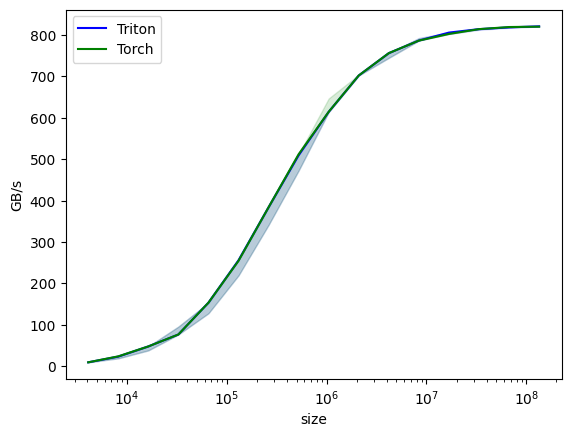

vector-add-performance:
           size      Triton       Torch
0        4096.0    9.600000    9.600000
1        8192.0   23.450383   24.000000
2       16384.0   48.000000   48.000000
3       32768.0   76.800002   76.800002
4       65536.0  153.600004  153.600004
5      131072.0  255.999991  254.673575
6      262144.0  384.000001  384.000001
7      524288.0  509.347151  511.999982
8     1048576.0  614.400016  614.400016
9     2097152.0  702.171410  702.171410
10    4194304.0  756.184613  756.184613
11    8388608.0  786.431963  786.431963
12   16777216.0  805.770507  802.481623
13   33554432.0  814.111783  814.111783
14   67108864.0  818.347569  819.200021
15  134217728.0  820.910214  820.074260


In [7]:
benchmark.run(print_data=True, show_plots=True, add_func=add)

# 2 Tile per CTA

In [8]:
@triton.jit
def add_kernel_v2(x_ptr,  
                  y_ptr, 
                  output_ptr, 
                  n_elements, 
                  num_block_per_CTA, 
                  BLOCK_SIZE: tl.constexpr, 
               ):
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE * num_block_per_CTA, 
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    for i in range(num_block_per_CTA):
        mask = offsets < n_elements
        x = tl.load(x_ptr + offsets, mask=mask)
        y = tl.load(y_ptr + offsets, mask=mask)
        output = x + y
        tl.store(output_ptr + offsets, output, mask=mask)
        offsets += BLOCK_SIZE

In [9]:
def add_v2(x: torch.Tensor, y: torch.Tensor):
    output = torch.empty_like(x)
    assert x.is_cuda and y.is_cuda and output.is_cuda
    n_elements = output.numel()
    num_block_per_CTA = 2
    BLOCK_SIZE = 1024
    grid = lambda meta: (triton.cdiv(n_elements, num_block_per_CTA * BLOCK_SIZE), 1, 1)
    add_kernel_v2[grid](x, y, output, n_elements, num_block_per_CTA, BLOCK_SIZE)
    return output

In [10]:
output_triton_v2 = add_v2(x, y)
print(f'The maximum difference between torch and triton v2 is '
      f'{torch.max(torch.abs(output_torch - output_triton_v2))}')

The maximum difference between torch and triton v2 is 0.0


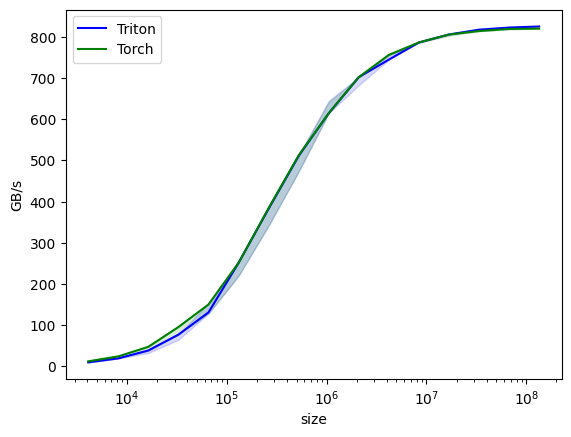

vector-add-performance:
           size      Triton       Torch
0        4096.0    9.600000   12.000000
1        8192.0   19.200000   24.000000
2       16384.0   38.400001   47.261538
3       32768.0   76.800002   95.255819
4       65536.0  130.723400  149.853661
5      131072.0  250.775518  250.775518
6      262144.0  382.505826  384.000001
7      524288.0  510.670140  511.999982
8     1048576.0  614.400016  614.400016
9     2097152.0  702.171410  702.171410
10    4194304.0  744.727267  756.184613
11    8388608.0  786.431963  786.431963
12   16777216.0  805.770507  805.770507
13   33554432.0  817.496889  814.111783
14   67108864.0  822.627612  819.200021
15  134217728.0  825.217226  820.054201


In [11]:
benchmark.run(print_data=True, show_plots=True, add_func=add_v2)

# 1 CTA for all Tiles

In [12]:
@triton.jit
def add_kernel_v3(x_ptr,  
                  y_ptr, 
                  output_ptr, 
                  n_elements, 
                  BLOCK_SIZE: tl.constexpr, 
               ):
    pid = tl.program_id(axis=0)
    offsets = tl.arange(0, BLOCK_SIZE)
    for i in range(0, n_elements, BLOCK_SIZE):
        mask = offsets < n_elements
        x = tl.load(x_ptr + offsets, mask=mask)
        y = tl.load(y_ptr + offsets, mask=mask)
        output = x + y
        tl.store(output_ptr + offsets, output, mask=mask)
        offsets += BLOCK_SIZE

In [13]:
def add_v3(x: torch.Tensor, y: torch.Tensor):
    output = torch.empty_like(x)
    assert x.is_cuda and y.is_cuda and output.is_cuda
    n_elements = output.numel()
    BLOCK_SIZE = 1024
    grid = (1, 1, 1)
    add_kernel_v3[grid](x, y, output, n_elements, BLOCK_SIZE)
    return output

In [14]:
output_triton_v3 = add_v3(x, y)
print(f'The maximum difference between torch and triton v3 is '
      f'{torch.max(torch.abs(output_torch - output_triton_v3))}')

The maximum difference between torch and triton v3 is 0.0


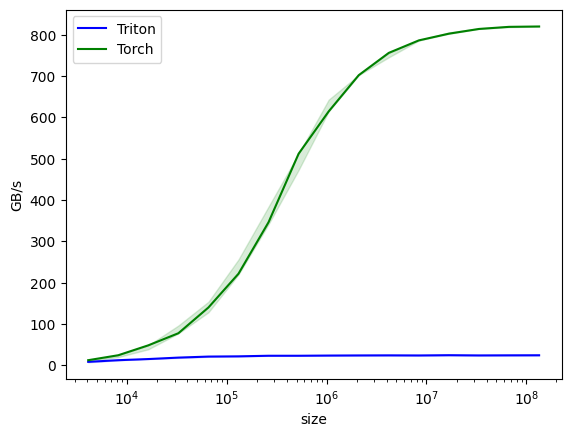

vector-add-performance:
           size     Triton       Torch
0        4096.0   8.000000   12.000000
1        8192.0  12.000000   24.000000
2       16384.0  14.769231   48.000000
3       32768.0  18.285714   77.283017
4       65536.0  20.756756  139.636363
5      131072.0  21.333333  221.405403
6      262144.0  22.755556  346.140834
7      524288.0  22.755556  511.999982
8     1048576.0  23.228733  614.400016
9     2097152.0  23.517702  702.171410
10    4194304.0  23.723440  756.184613
11    8388608.0  23.472778  786.431963
12   16777216.0  24.111846  802.686439
13   33554432.0  23.554331  814.111783
14   67108864.0  23.783707  819.200021
15  134217728.0  23.939363  820.080930


In [15]:
benchmark.run(print_data=True, show_plots=True, add_func=add_v3)